

Python version: 3.7.12 (Google Colab)

Libraries used (in order of usage):
- numpy
- csv
- os
- tqdm
- matplotlib.pyplot
- torch
- pandas

## Extracting Data

Image data and their respective annotations were first extracted from the relevant npz and csv files. There is a discrepancy noted in the number of entries csv/npz files; namely, the **csv file contains one extra row when compared to its corresponding npz file**.

This discrepancy throws an `IndexError` when attempting to match the images to their annotations. Under normal circumstances, I would clarify if the data given is indeed correct, before even proceeding to train a neural network. However, the exception is caught in a `try` block for this case.



In [ ]:
import numpy as np
import csv
import os
from tqdm import tqdm # just a progress bar

###############
## CONSTANTS ##
###############

NPZ_DIRPATH = "drive/MyDrive/AngioAssessment/npz"
CSV_DIRPATH = "drive/MyDrive/AngioAssessment/csv"

FNAME = 'arr_0'
NUM_FILES = 5

## keyframed and non-keyframed data stored differently for now.
data = {"1" : [], # keyframed
        "0" : []} # non-keyframed

def prepare_data():
  """ Reads and prepares image and annotation data for future processing. 
  Mainly, the annotations are appended to their corresponding images.

  Global variable :data: populated with the annotated images.
  """
  def annotate_data(npz_fpath, csv_fpath):
    """ Handles the reading of files as well as the annotation of images. 

    Annotations are converted into a one-hot vector. 
    """
    csv_data = csv.reader(open(csv_fpath, 'r'))
    npz_data = np.load(npz_fpath)[FNAME]

    for index, anno in tqdm(csv_data):
      # data reading enclosed in try-except 
      # due to the one extra row in the csv file
      try:
        data[anno].append([npz_data[int(index)], np.eye(2)[int(anno)]])
      except Exception as e:
        pass

  for i in range(1, 1+NUM_FILES):
    npz_fpath = os.path.join(NPZ_DIRPATH, f"npz-{i}.npz")
    csv_fpath = os.path.join(CSV_DIRPATH, f"csv-{i}.csv")
    annotate_data(npz_fpath, csv_fpath)

prepare_data() 

---
## Image Visualisation

The two images below are examples of a keyframed and non-keyframed image respectively. Both images are taken from `npz-1.npz`.

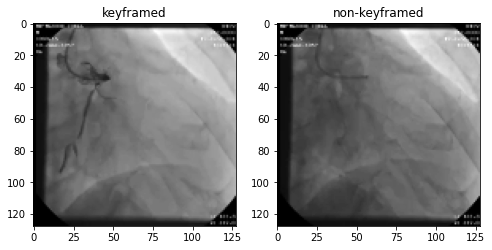

In [2]:
import matplotlib.pyplot as plt

# Extract example of keyframed and non-keyframed data
keyframed_img_eg = data['0'][0]
non_keyframed_img_eg = data['1'][0]

images = list(map(lambda x:x[0][0,:,:], [keyframed_img_eg, non_keyframed_img_eg]))
titles = ["keyframed", "non-keyframed"]

# configure plot area
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 6)

# plot images
for i in range(len(images)):
  img = images[i]; title = titles[i]
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(title)

plt.show()

---
## Preparing Data

The data can be viewed as unbalanced, as the counts of keyframed and non-keyframed data are not exactly equal:

In [3]:
print(f"Keyframed count: {len(data['1'])}\nNon-keyframed count: {len(data['0'])}")

Keyframed count: 394
Non-keyframed count: 300


Balancing will be performed by undersampling the majority (keyframed images).

In [4]:
def process_data(data):
  def shuffled_balance(data):
    """ Perform undersampling for the majority data.
    Shuffling is performed first followed by balancing. 
    """
    ls_1, ls_2 = data.values()
    map(np.random.shuffle, (ls_1, ls_2)) # in-place shuffling of both lists

    a, b = len(ls_1), len(ls_2)
    target = max(a, b) - abs(a - b) # target length of both lists 

    # slice to target length
    data['1'] = ls_1[:target] 
    data['0'] = ls_2[:target]

  shuffled_balance(data)

  # verify that both image lists are equal
  assert(len(data['0']) == len(data['1'])) 

  concat = data['1'] + data['0']
  
  # shuffle the concatenated dataset once more
  np.random.shuffle(concat)
  return concat

processed_data = process_data(data)

---
## Neural network

In [5]:
"""
NN
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # nn.Conv2d takes the in_channel, out_channel, kernel size
    # the image, being greyscale, only has one channel
    self.conv_1 = nn.Conv2d(1, 32, 3) 
    self.conv_2 = nn.Conv2d(32, 64, 3)
    self.conv_3 = nn.Conv2d(64, 128, 3)

    # Handles the initialisation of in_channels for the first fully connected layer
    self._to_linear = None
    rand_init = torch.randn(128, 128).view(-1, 1, 128, 128) # pass in random data
    self.run_conv(rand_init)

    # fully connected layers to finally output keyframed or non-keyframed
    self.fc_1 = nn.Linear(self._to_linear, 128)
    self.fc_2 = nn.Linear(128, 2)

  def run_conv(self, x):
    # relu; "discard" negative values
    # max pooling; (2, 2) filter
    x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv_2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv_3(x)), (2, 2))

    # init in_channels for fc_1
    if not self._to_linear:
      self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  def forward(self, x):
    x = self.run_conv(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc_1(x))
    x = self.fc_2(x) # relu not needed, just output the final result
    return F.softmax(x, dim=1) # rescale elements to sum to 1

####################
## HYPERPARAMETER ##
####################
LEARNING_RATE = 3e-4

net = Net()
optimiser = optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()

---
## Partion data

The existing dataset is split into training and validation data. Testing data is omitted. 

In [6]:
SPLIT_PCT = 0.2 # % of the data used for validation

""" Normalise pixel values to [0, 1] """
# Pixel value normalisation does not affect the ability to view to image, 
# however, the learning process should be sped up with these smaller values
imgs = torch.Tensor(np.array([i[0] for i in processed_data])).view(-1, 128, 128)/255.0
annos = torch.Tensor(np.array([i[1] for i in processed_data]))

val_size = int(len(imgs)*SPLIT_PCT)

training_imgs = imgs[val_size:]
training_annos = annos[val_size:]

val_imgs = imgs[:val_size]
val_annos = annos[:val_size]

---
## Training and validating functions

In [7]:
from random import sample

def calc_batch_performance(outputs, annotations):
  """ Calculates and returns a confusion matrix for the current batch of data.
  The confusion matrix should look as follows:

  confusion_mat
  -------------
  |         | non_kf    | kf        |
  | non_kf  | true neg  | fals neg  | 
  | kf      | false pos | true pos  | 

  """
  confusion_mat = [[0, 0], 
                   [0, 0]]

  for i, j in zip(outputs, annotations):
    confusion_mat[torch.argmax(i)][torch.argmax(j)] += 1
  
  num_correct = confusion_mat[0][0] + confusion_mat[1][1]
  accuracy = num_correct / sum(map(sum, confusion_mat))
  
  return confusion_mat, accuracy


def forward_pass(images, annotations, training=False):
  """ Handles the forward pass of the given image/annotation batch.
  """
  images = images.view(-1, 1, 128, 128)

  if training:
    net.zero_grad()

  outputs = net(images)
  confusion_mat, accuracy = calc_batch_performance(outputs, annotations) 
  
  loss = loss_fn(outputs, annotations)

  if training:
    loss.backward()
    optimiser.step()

  return confusion_mat, accuracy, loss

def validate(size):
  """ Take random slices of the validation dataset and return the confusion matrix, 
  accuracy, and loss.

  :size: represents the batch size for validation. 
  """
  random_start = np.random.randint(len(val_imgs)-size)
  sampled_imgs = val_imgs[random_start:random_start+size]
  sampled_annos = val_annos[random_start:random_start+size]
  
  with torch.no_grad():
    confusion_mat, accuracy, loss = forward_pass(sampled_imgs, sampled_annos)
  return confusion_mat, accuracy, loss


---
## Training the network

Train the network and validate at consistent time intervals. In this case, validation is performed every **10 iterations** within a single epoch. Accuracy, loss and confusion matrices are collected as evaluation metrics.

In [ ]:
## collect accuracy and loss values, as well as confusion matrices from training and validation 
accuracy_values = []
loss_values = []
confusion_mats = []

#####################
## HYPERPARAMETERS ##
#####################
BATCH_SIZE = 32
EPOCHS = 20

def train():
  for epoch in range(EPOCHS):
    print(f'Current epoch: {epoch}') # just for progress visualisation
    for i in tqdm(range(0, len(training_imgs), BATCH_SIZE)):
      batch_imgs = training_imgs[i:i+BATCH_SIZE]
      batch_annos = training_annos[i:i+BATCH_SIZE]
      conf_mat, acc, loss = forward_pass(batch_imgs, batch_annos, training=True)

      if i % 10 == 0: # every ten iterations, test and collect eval metrics
        val_conf_mat, val_acc, val_loss = validate(BATCH_SIZE)
        confusion_mats.append([conf_mat, val_conf_mat])
        accuracy_values.append([acc, val_acc])
        loss_values.append([loss.item(), val_loss.item()])

train()

---
## Visualising network validation

The section below is mostly concerned with visualsing evluation metrics collected from network validation. However, the multiple runs done were saved separately and just displayed as final plots. 

#### Helper functions for parsing the confusion matrix

The helper functions below calculate the precision/recall values from the confusion matrices, as well as the corresponding f-measure.

In [9]:
def get_precision_recall(mat):
  """ Returns a list of [precision, recall] values given a confusion matrix. """
  tp, fp = mat[1][1], mat[1][0]
  tn, fn = mat[0][0], mat[0][1]

  precision = 0 if tp + fp == 0 else tp / (tp + fp)
  recall = 0 if tp + fn == 0 else tp / (tp + fn)
  return [precision, recall]

def get_f(precision_recall):
  """ Returns the f-measure given a list of [precision, recall] values. """
  precision, recall = precision_recall
  return 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall) 

## maps the getter functions on a list of lists, where the zeroth index of each list represents
## evaluation metrics from training, while the first index of each list represents that from validation
precision_recall_values = list(map(lambda x : list(map(get_precision_recall, x)), confusion_mats))
f_values = list(map(lambda x : list(map(get_f, x)), precision_recall_values))

#### Plotting evalutation metrics

In [ ]:
import pandas as pd

""" Handles data plotting. """ 

WINDOW = 10

# Get rolling average for a smoother plot
acc_df = pd.DataFrame.from_records(accuracy_values). \
          rename(columns={0 : 'training', 1 : 'testing'}). \
          rolling(window = WINDOW).mean()

loss_df = pd.DataFrame.from_records(loss_values). \
          rename(columns={0 : 'training', 1 : 'testing'}). \
          rolling(window = WINDOW).mean()

f_df = pd.DataFrame.from_records(f_values). \
          rename(columns={0 : 'training', 1 : 'testing'}). \
          rolling(window = WINDOW).mean()

# figure formatting
res_fig, res_axes = plt.subplots(nrows=3)
res_fig.set_size_inches(8, 8)

res_fig.suptitle("learning rate: " + str(LEARNING_RATE))

acc_df.plot(ax=res_axes[0], title="Accuracy")
loss_df.plot(ax=res_axes[1], title="Loss")
f_df.plot(ax=res_axes[2], title="F-measure")

plt.tight_layout()
res_fig.subplots_adjust(top=0.9)

## resulting figures were simply saved as png files for display later.

---
## Hyperparameter optimisation

The number of epochs, learning rate, and batch size were tweaked after validating the network. The current hyperparameters were deemed to be the best after multiple changes. 
> As an aside, having no prior experience regarding image classification and neural networks, the hyperparameters used were derived from popular suggestions found online. Minor tweaks were made if necessary, of course. 

The figures below only show the results of **changing learning rates** on model accuracy, loss, and the F-measure. The number of epochs and batch size remained constant at 20 and 32 respectively. 

### 1
![](https://drive.google.com/uc?export=view&id=1Fu3f6HoeOjzpGemgnbPuavKSn1k1mSoW)



### 2
![](https://drive.google.com/uc?export=view&id=1byg50aL1SDeoPHqLxuPqU2BmRiSxHfVD)

### 3
![](https://drive.google.com/uc?export=view&id=1WBUx2rLLvoKr_tfFlqcyFFu_2MFXP9Vr)

_Figure 1, 2, 3: Orange lines represent rolling averages of testing (validation) evaluation metrics, while blue lines represent that of training evaluation metrics._

Note:
> The number of epochs chosen for visualisation is in part due to physical (and temporal) constraints. Ideally, I would be able to offset the training of the model to a HPC. More importantly, the loss function was noted to increase again (for the training dataset) after hundreds of epochs, which suggests overfitting. 


---
## Final comments

1. The task in the assessment required two DL neural networks to be implemented. The lack of a second network is not an oversight, rather a limitation of my current knowledge and ability in this field.
2. I would implement at least 5-fold cross-validation, especially given the relatively small size of the dataset provided. However, due to time constraints, this was not implemented in time.

---
